In [1]:
import altair as alt
import numpy as np
import pandas as pd
import pandas_gbq
import os.path
import seaborn as sns
import category_encoders as ce
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
thres_swipe = .7
thres_speaker = .7
thres_loan = .6

In [4]:
alt.data_transformers.enable('default', max_rows=None)
pd.options.display.max_columns = None

In [5]:
merchants = pd.read_csv('overall_merchant.csv')
# trx = pd.read_csv('overall_trx.csv')
app = pd.read_csv('overall_app.csv')

In [6]:
trx1 = pd.read_csv('trx1.csv')
payee1 = pd.read_csv('payee1.csv')
payee2 = pd.read_csv('payee2.csv')

In [7]:
##### start

In [8]:
# merchant_test = [8558339,328509,11540219,5412519,24599030,11540219,9192549]

# trx1[trx1['merchant_id'].isin(merchant_test)]

# payee1[payee1['merchant_id'].isin(merchant_test)]

# payee2[payee2['merchant_id'].isin(merchant_test)]

# app[app['merchant_id'].isin(merchant_test)]

In [9]:
##### 24599030
##### D12F1B696A34419F93EBEF2B4F75F68B

##### 8558339
##### 1E507C644169441C834677170D8A6A2F

In [10]:
# merchants[merchants['merchant_id'].isin(merchant_test)]

In [11]:
# list(merchants[merchants['merchant_id'].isin(merchant_test)]['mid'])

In [12]:
##### end

In [13]:
print(f"There are a total of {merchants.shape[0]} merchants having more than 5 trxn in last 90 days and created after 2022-01-01")

There are a total of 2700031 merchants having more than 5 trxn in last 90 days and created after 2022-01-01


In [14]:
pdt_final = pd.DataFrame()
pdt_final['merchant_id'] = merchants['merchant_id']

In [15]:
geo = 'geohash4'
rel_cols = ['merchant_id', 'vintage','zone_name','business_category',geo,'speaker_eligibility','swipe_eligibility','lending_eligibility']

pdt = merchants[rel_cols]

In [16]:
pdt_final = pdt_final.merge(pdt, how = 'left', left_on = "merchant_id", right_on = "merchant_id")

In [17]:
# pdt_final = pdt_final.merge(trx, how = 'left', left_on = "merchant_id", right_on = "merchant_id")

In [18]:
pdt_final = pdt_final.merge(trx1, how = 'left', left_on = "merchant_id", right_on = "merchant_id")
pdt_final = pdt_final.merge(payee1, how = 'left', left_on = "merchant_id", right_on = "merchant_id")
pdt_final = pdt_final.merge(payee2, how = 'left', left_on = "merchant_id", right_on = "merchant_id")

In [19]:
pdt_final = pdt_final.merge(app, how = 'left', left_on = "merchant_id", right_on = "merchant_id")

In [20]:
c1 = pdt_final['w1_txn_count'] - pdt_final['w2_txn_count']
c2 = pdt_final['w2_txn_count'] - pdt_final['w3_txn_count']
pdt_final['trend'] = np.where((c1>0) & (c2>0), "up",np.where((c1<0) & (c2<0),"down","flat"))

In [21]:
pdt_final.shape

(2700031, 50)

In [22]:
# pdt_final[pdt_final['txn_count_90_days'].isna()]

In [23]:
pdt_final = pdt_final[~pdt_final['txn_count_90_days'].isna()]

In [24]:
device = """
SELECT * FROM `bharatpe-analytics-prod.bharatpe_ml_data.merchant_device_info`
"""
device = pandas_gbq.read_gbq(device)

Downloading: 100%|██████████| 9236615/9236615 [04:51<00:00, 31685.55rows/s]


In [25]:
pdt_final = pdt_final.merge(device[['merchant_id','manufacturer']], how = 'left', left_on = "merchant_id", right_on = "merchant_id")

In [26]:
major_brands = ['vivo',
 'samsung',
 'other',
 'xiaomi',
 'oppo',
 'realme',
 'oneplus',
 'apple',
 'motorola',
 'tecno',
 'huawei',
 'infinix',
 'hmd',
 'lge',
 'lenovo',
 'asus',
 'itel',
 'google',
 'lava',
 'micromax']

In [27]:
pdt_final['manufacturer'] = pdt_final['manufacturer'].str.lower()
pdt_final['manufacturer'] = pdt_final['manufacturer'].replace({'tecno mobile limited': 'tecno', 'infinix mobility limited': 'infinix', 'hmd global': 'hmd'\
                                   , 'itel mobile limited': 'itel'})

# major_brands = list(pdt_final['manufacturer'].str.lower().value_counts()[:20].index)

pdt_final['manufacturer'] = np.where(pdt_final['manufacturer'].isin(major_brands),pdt_final['manufacturer'], 'other')
# pdt_final['version'] = pdt_final['version'].apply(lambda x :"new" if x in ('11','12') else 'old')

In [28]:
del(device)

In [29]:
loc_hash_density = pdt_final.groupby(geo).apply(lambda x:x['merchant_id'].nunique()).sort_values(ascending = False).to_dict()
pdt_final['loc_hash_density'] = pdt_final[geo].map(loc_hash_density)

In [30]:
loc_hash_atv = pdt_final.groupby(geo).apply(lambda x:x['total_tpv'].sum()/ len(x)).sort_values(ascending = False).to_dict()
pdt_final['loc_hash_atv'] = pdt_final[geo].map(loc_hash_atv)

In [31]:
loc_hash_tpv = pdt_final.groupby(geo).apply(lambda x:x['total_tpv'].sum()).sort_values(ascending = False).to_dict()
pdt_final['loc_hash_tpv'] = pdt_final[geo].map(loc_hash_tpv)

In [32]:
pdt_final['m1_atv'] = pdt_final['m1_tpv']/pdt_final['m1_txn_count']
pdt_final['m2_atv'] = pdt_final['m2_tpv']/pdt_final['m2_txn_count']
pdt_final['total_atv'] = pdt_final['total_tpv']/pdt_final['total_txn_count']
pdt_final['txn_activeday'] = pdt_final['total_txn_count']/pdt_final['total_active_vintage']
pdt_final['m1_txn_activeday'] = pdt_final['m1_txn_count']/pdt_final['m1_active_days']
pdt_final['m2_txn_activeday'] = pdt_final['m2_txn_count']/pdt_final['m2_active_days']
# pdt_final['m3_txn_activeday'] = pdt_final['m3_txn_count']/pdt_final['m3_active_days']
pdt_final['m1_max_daily_by_tpv'] = pdt_final['m1_max_daily_tpv']/pdt_final['m1_tpv']
# pdt_final['m2_max_daily_by_tpv'] = pdt_final['m2_max_daily_tpv']/pdt_final['m2_tpv']
# pdt_final['m3_max_daily_by_tpv'] = pdt_final['m3_max_daily_tpv']/pdt_final['m3_tpv']
pdt_final['m1_max_daily_by_payees'] = pdt_final['m1_max_daily_payees']/pdt_final['m1_unique_payers']
pdt_final['m1_max_daily_by_txns'] = pdt_final['m1_max_daily_txns']/pdt_final['m1_txn_count']

In [33]:
ONE_HOT_COLS = ['zone_name', 'business_category', 'trend',geo,'manufacturer']

for c in ONE_HOT_COLS:
    pdt_final[c].fillna(pdt_final[c].mode(), inplace=True)

In [34]:
# nan_ind = list(pdt_final[pdt_final[ONE_HOT_COLS].isnull().any(axis=1) == 1].index)
# pdt_final = pdt_final[~pdt_final.index.isin(nan_ind)]

In [35]:
num_cols = list(pdt_final.columns[pdt_final.dtypes!=np.object][2:])
cat_cols = pdt_final.columns[pdt_final.dtypes==np.object]

In [36]:
pdt_final.loc[pdt_final['vintage']<0,'vintage']=0

In [37]:
for c in ONE_HOT_COLS:
    pdt_final[c] = pdt_final[c].astype("category")

In [38]:
base_cols = ['w1_unique_payers', 'w2_unique_payers', 'm1_unique_payers',
       'm2_unique_payers', 'm3_unique_payers', 'unique_payers_90_days',
       'total_unique_payers', 'w1_txn_count', 'w2_txn_count', 'w3_txn_count',
       'm1_txn_count', 'm2_txn_count', 'm3_txn_count', 'txn_count_90_days',
       'total_txn_count', 'total_active_vintage', 'w1_tpv', 'w2_tpv', 'm1_tpv',
       'm2_tpv', 'm3_tpv', 'tpv_90_days', 'total_tpv', 'm1_active_days',
       'm2_active_days', 'm3_active_days', 'm1_max_daily_tpv',
       'm2_max_daily_tpv', 'm3_max_daily_tpv', 'm1_max_daily_payees',
       'm2_max_daily_payees', 'm3_max_daily_payees', 'm1_max_daily_txns',
       'm2_max_daily_txns', 'm3_max_daily_txns', 'm1_atv', 'm2_atv',
       'total_atv', 'txn_activeday', 'm1_txn_activeday', 'm2_txn_activeday',
       'm1_max_daily_by_tpv', 'm1_max_daily_by_payees', 'm1_max_daily_by_txns',
       'zone_name', 'business_category', 'trend', geo,'vintage','manufacturer','loc_hash_density','loc_hash_atv','loc_hash_tpv']

In [39]:
# del(merchants)
# del(trx)
del(app)
del(trx1)
del(payee1)
del(payee2)

In [40]:
##### swipe inference

In [41]:
product = "swipe"
final_cols = base_cols + [f'w1_{product}_sessions',f'm1_{product}_sessions']

X_swipe = pdt_final[final_cols]

X_swipe_merchant = pdt_final['merchant_id']

X_swipe.rename(columns = {f'w1_{product}_sessions':'w1_sessions', f'm1_{product}_sessions':'m1_sessions'}, inplace = True)

clf = pickle.load(open(f"{product}_model", 'rb'))

swipe_f = pd.DataFrame()
swipe_f['merchant_id'] = X_swipe_merchant
swipe_f[f'prob_{product}'] = clf.predict_proba(X_swipe)[:,1]

# swipe_f[f'pred_{product}_buy'] = np.where(swipe_f[f'p_{product}']>.5,1,0)

# swipe_f[f'{product}_flag'] = swipe_f['merchant_id'].map(swipe_mer)
# swipe_f.sort_values(by=[f'p_{product}'], ascending = False, inplace = True)
# app_merchants = pd.read_csv(f'{product}_total_application_merchants.csv')
# swipe_f[f'{product}_application'] = np.where(swipe_f['merchant_id'].isin(app_merchants['merchant_id']),1,0)
swipe_f.head()

,merchant_id,prob_swipe
0,35015940,0.361982
1,35016250,0.367602
2,11021470,0.236049
3,11020900,0.117694
4,11022540,0.000106


In [42]:
swipe_map = swipe_f.set_index('merchant_id')['prob_swipe'].to_dict()

pdt_final['prob_swipe'] = pdt_final['merchant_id'].map(swipe_map)

In [43]:
# swipe_f[swipe_f['swipe_flag'] ==1]['p_swipe'].mean()

In [44]:
# swipe_f[swipe_f['swipe_flag'] ==0]['p_swipe'].mean()

In [45]:
swipe_f.to_csv("swipe_f.csv", index = False)
del(swipe_f)

In [46]:
##### speaker inference

In [47]:
product = "speaker"
final_cols = base_cols + [f'w1_{product}_sessions',f'm1_{product}_sessions']

X_speaker = pdt_final[final_cols]

X_speaker_merchant = pdt_final['merchant_id']

X_speaker.rename(columns = {f'w1_{product}_sessions':'w1_sessions', f'm1_{product}_sessions':'m1_sessions'}, inplace = True)

clf = pickle.load(open(f"{product}_model", 'rb'))

speaker_f = pd.DataFrame()
speaker_f['merchant_id'] = X_speaker_merchant
speaker_f[f'prob_{product}'] = clf.predict_proba(X_speaker)[:,1]

# speaker_f[f'pred_{product}_buy'] = np.where(speaker_f[f'p_{product}']>.5,1,0)

# speaker_f[f'{product}_flag'] = speaker_f['merchant_id'].map(speaker_mer)
# speaker_f.sort_values(by=[f'p_{product}'], ascending = False, inplace = True)
# app_merchants = pd.read_csv(f'{product}_total_application_merchants.csv')
# speaker_f[f'{product}_application'] = np.where(speaker_f['merchant_id'].isin(app_merchants['merchant_id']),1,0)
speaker_f.head()

,merchant_id,prob_speaker
0,35015940,0.576731
1,35016250,0.711347
2,11021470,0.690153
3,11020900,0.296064
4,11022540,0.000027


In [48]:
speaker_map = speaker_f.set_index('merchant_id')['prob_speaker'].to_dict()

pdt_final['prob_speaker'] = pdt_final['merchant_id'].map(speaker_map)

In [49]:
# speaker_f[speaker_f['speaker_flag'] ==1]['p_speaker'].mean()

In [50]:
# speaker_f[speaker_f['speaker_flag'] ==0]['p_speaker'].mean()

In [51]:
speaker_f.to_csv("speaker_f.csv", index = False)
del(speaker_f)

In [52]:
##### loan inference

In [53]:
%whos DataFrame

Variable    Type         Data/Info
----------------------------------
X_speaker   DataFrame             w1_unique_payers<...>658596 rows x 55 columns]
X_swipe     DataFrame             w1_unique_payers<...>658596 rows x 55 columns]
merchants   DataFrame             merchant_id     <...>700031 rows x 38 columns]
pdt         DataFrame             merchant_id  vin<...>2700031 rows x 8 columns]
pdt_final   DataFrame             merchant_id  vin<...>658596 rows x 65 columns]


In [54]:
del(pdt)
del(X_speaker)
del(X_swipe)

In [55]:
product = "loan"
final_cols = base_cols + [f'w1_{product}_sessions',f'm1_{product}_sessions']

X_loan = pdt_final[final_cols]

X_loan_merchant = pdt_final['merchant_id']

X_loan.rename(columns = {f'w1_{product}_sessions':'w1_sessions', f'm1_{product}_sessions':'m1_sessions'}, inplace = True)

clf = pickle.load(open(f"{product}_model", 'rb'))

loan_f = pd.DataFrame()
loan_f['merchant_id'] = X_loan_merchant
loan_f[f'prob_{product}'] = clf.predict_proba(X_loan)[:,1]

# loan_f[f'pred_{product}_buy'] = np.where(loan_f[f'p_{product}']>.5,1,0)

# loan_f[f'{product}_flag'] = loan_f['merchant_id'].map(loan_mer)
# loan_f.sort_values(by=[f'p_{product}'], ascending = False, inplace = True)
# app_merchants = pd.read_csv(f'{product}_total_application_merchants.csv')
# loan_f[f'{product}_application'] = np.where(loan_f['merchant_id'].isin(app_merchants['merchant_id']),1,0)
loan_f.head()

,merchant_id,prob_loan
0,35015940,0.749113
1,35016250,0.312718
2,11021470,0.061308
3,11020900,0.431917
4,11022540,0.000614


In [56]:
loan_map = loan_f.set_index('merchant_id')['prob_loan'].to_dict()

pdt_final['prob_loan'] = pdt_final['merchant_id'].map(loan_map)

In [57]:
# loan_f[loan_f['loan_flag'] ==1]['p_loan'].mean()

In [58]:
# loan_f[loan_f['loan_flag'] ==0]['p_loan'].mean()

In [59]:
loan_f.to_csv("loan_f.csv", index = False)
del(loan_f)
del(X_loan)

In [60]:
swipe_mer = merchants.set_index('merchant_id')['swipe_flag'].to_dict()
speaker_mer = merchants.set_index('merchant_id')['speaker_flag'].to_dict()
loan_mer = merchants.set_index('merchant_id')['loan_flag'].to_dict()

In [61]:
pdt_final['swipe_flag'] = pdt_final['merchant_id'].map(swipe_mer)
pdt_final['speaker_flag'] = pdt_final['merchant_id'].map(speaker_mer)
pdt_final['loan_flag'] = pdt_final['merchant_id'].map(loan_mer)

In [62]:
del(swipe_mer)
del(speaker_mer)
del(loan_mer)

In [63]:
def loan_ltv(x):
    # x = pdt_final.loc[0,['lending_eligibility', 'prob_loan','m1_tpv','m2_tpv']]
    avg_tpv = (x['m1_tpv'] + x['m2_tpv'])/2
    disposable_amount = .5*avg_tpv*2 # 2 loans per merchant
    ltv = 6*.12*disposable_amount*x['prob_loan']*x['lending_eligibility']
    return ltv

In [64]:
pdt_final['loan_ltv'] = pdt_final.loc[:,['lending_eligibility', 'prob_loan','m1_tpv','m2_tpv']].apply(lambda x:loan_ltv(x), axis=1)

In [65]:
def speaker_ltv(x):
    # x = pdt_final.loc[0,['speaker_eligibility', 'prob_speaker','m1_tpv','m2_tpv']]
    ltv = 12*120*x['prob_speaker']*x['speaker_eligibility']
    return ltv

In [66]:
pdt_final['speaker_ltv'] = pdt_final.loc[:,['speaker_eligibility', 'prob_speaker','m1_tpv','m2_tpv']].apply(lambda x:speaker_ltv(x), axis=1)

In [67]:
def swipe_ltv(x):
    avg_tpv = (x['m1_tpv'] + x['m2_tpv'])/2
    ltv = avg_tpv*12*.02*x['prob_swipe']*x['swipe_eligibility']
    return ltv

In [68]:
pdt_final['swipe_ltv'] = pdt_final.loc[:,['swipe_eligibility', 'prob_swipe','m1_tpv','m2_tpv']].apply(lambda x:swipe_ltv(x), axis=1)

In [69]:
pdt_final['mltv'] = pdt_final['loan_ltv'] + pdt_final['speaker_ltv'] +pdt_final['swipe_ltv']

In [70]:
# pdt_final['prob_loan'].hist(bins = 100)

In [71]:
# pdt_final['prob_swipe'].hist()

In [72]:
# pdt_final['prob_speaker'].hist()

In [73]:
def order_reco(x):
    # x = pdt_final.loc[9,['prob_loan','prob_swipe','prob_speaker']]
    x=x.to_dict()
    x['prob_loan'] = x['prob_loan'] - thres_loan
    x['prob_swipe'] = x['prob_swipe'] - thres_swipe
    x['prob_speaker'] = x['prob_speaker'] - thres_speaker
    sorted_elems = sorted(x.items(), key=lambda x: -x[1])
    r1,r2,r3 = sorted_elems[0][0].replace("prob_",""),sorted_elems[1][0].replace("prob_",""),sorted_elems[2][0].replace("prob_","")
    return [r1,r2,r3]

# def order_reco(x):
#     # x = pdt_final.loc[9,['prob_loan','prob_swipe','prob_speaker']]
#     first = x.max()
#     first_reco = x[x == first].index[0]
#     third = x.min()
#     third_reco = x[x == third].index[0]
#     considered = [first_reco, third_reco]
#     second_reco = list(set(['prob_loan','prob_swipe','prob_speaker']) - set(considered))[0]
#     order = [first_reco, second_reco, third_reco]
#     r1, r2, r3 = [it.replace("prob_","") for it in order]
#     return r1,r2,r3

In [74]:
pdt_final[['p1_recommendation', 'p2_recommendation', 'p3_recommendation']] = pdt_final.loc[:,['prob_loan','prob_swipe','prob_speaker']].apply(lambda x:order_reco(x), axis=1,result_type='expand')

In [75]:
digital_mer = pd.read_csv("digital_merchants.csv")

In [76]:
pdt_final['Channel'] = np.where(pdt_final['merchant_id'].isin(digital_mer['merchant_id']),"Digital","Offline")

In [77]:
pdt_final.to_gbq("bharatpe_ml_data.pdt_final", project_id="bharatpe-analytics-prod",if_exists='replace')

100%|██████████| 1/1 [00:00<00:00, 6269.51it/s]


In [78]:
pdt_final.to_csv("Final_Data.csv", index = False)

In [79]:
#####

<AxesSubplot:>

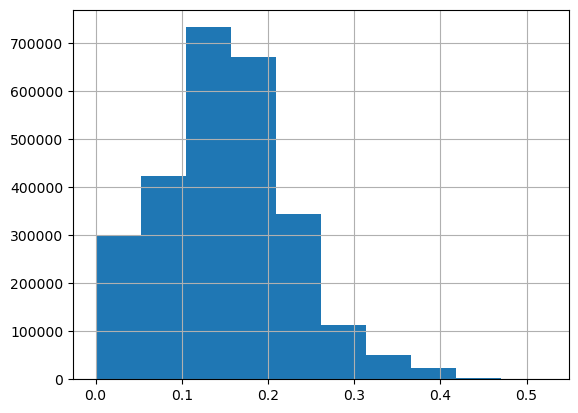

In [80]:
pdt_final['prob_swipe'].hist()

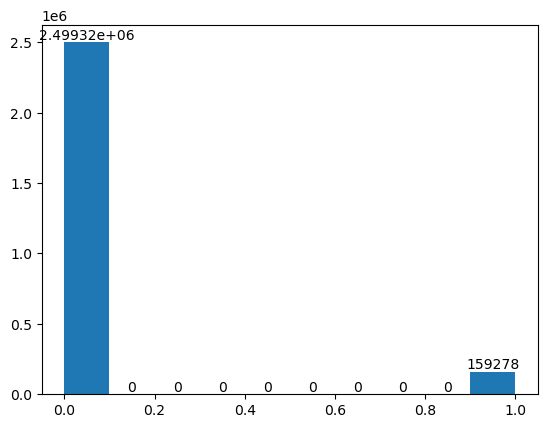

In [81]:
counts, edges, bars = plt.hist(pdt_final['swipe_flag'])
plt.bar_label(bars)
plt.show()

<AxesSubplot:>

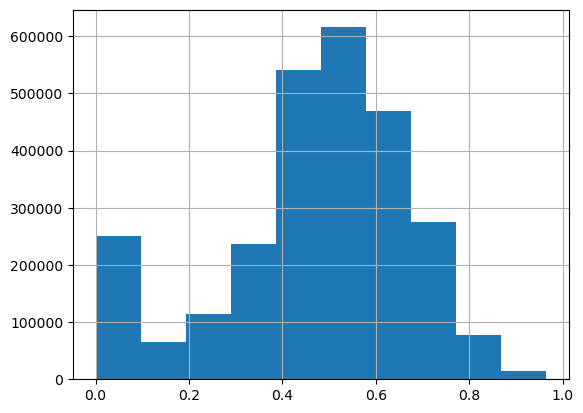

In [82]:
pdt_final['prob_speaker'].hist()

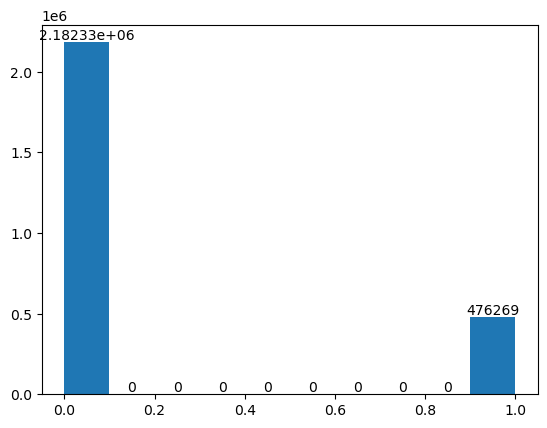

In [83]:
counts, edges, bars = plt.hist(pdt_final['speaker_flag'])
plt.bar_label(bars)
plt.show()

<AxesSubplot:>

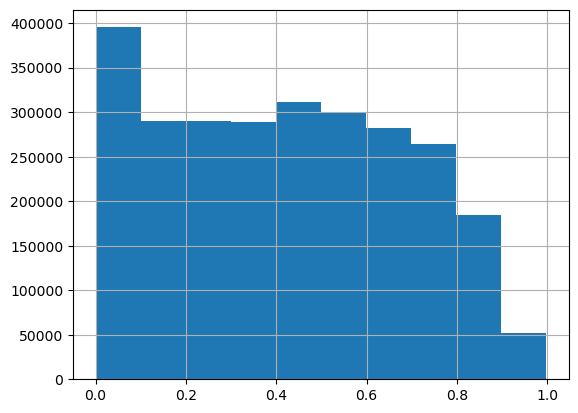

In [84]:
pdt_final['prob_loan'].hist()

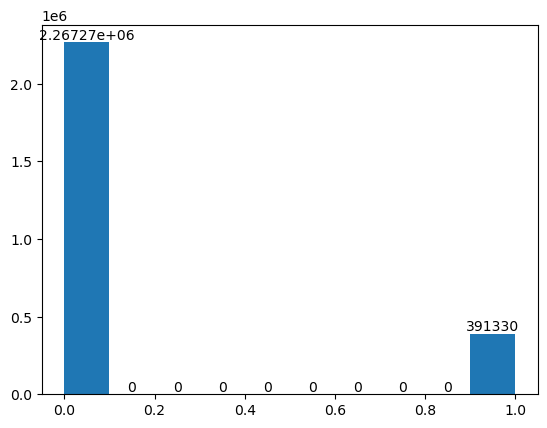

In [85]:
counts, edges, bars = plt.hist(pdt_final['loan_flag'])
plt.bar_label(bars)
plt.show()

In [86]:
%whos DataFrame

Variable      Type         Data/Info
------------------------------------
digital_mer   DataFrame            merchant_id\n0   <...>[337382 rows x 1 columns]
merchants     DataFrame             merchant_id     <...>700031 rows x 38 columns]
pdt_final     DataFrame             merchant_id  vin<...>658596 rows x 77 columns]


In [87]:
#### EDA

In [88]:
imp_var = ['merchant_id','total_txn_count','m1_tpv','total_atv','total_unique_payers'\
           ,'m1_atv','m1_max_daily_tpv','m1_active_days','total_active_vintage','w1_loan_sessions',\
           'w1_swipe_sessions', 'w1_speaker_sessions','m1_loan_sessions','m1_swipe_sessions', \
           'm1_speaker_sessions', 'swipe_flag', 'speaker_flag', 'loan_flag','zone_name', 'business_category', geo]

In [89]:
vis_df = pdt_final[imp_var]

In [90]:
def cat_alt(col, pdt = 'swipe'):
    # col = 'business_category'
    df = (100*vis_df.groupby(col)[f"{pdt}_flag"].mean()).to_frame().reset_index()
    df['Count of Merchants'] = list(vis_df.groupby(col)["merchant_id"].count())
    alt.themes.enable('fivethirtyeight')
    base = alt.Chart(df).encode(x=alt.X(f'{col}:N',axis=alt.Axis(title="") ))

    bar = base.mark_bar(color = 'lightgrey').encode(y=alt.Y(f'{pdt}_flag:Q',axis=alt.Axis(title=f"{pdt}_flag %")))

    line =  base.mark_line(color='aqua').encode(
        y='Count of Merchants:Q'
    )
    txt_bar = bar.mark_text(align='center',
            baseline='middle',
            dy=-6
    ).encode(
        y=alt.Y(f'{pdt}_flag:Q',axis=alt.Axis(title="",labels=False,ticks=False)),
        text=alt.Text(f'{pdt}_flag:Q',format='1.0d')
    )

    txt_line = line.mark_text(align='center',
            baseline='middle',
            dy=-6, angle = 80, color = 'black'
    ).encode(
        text=alt.Text('Count of Merchants:Q',format='1.0d')
    )

    c = (bar + txt_bar+ line +txt_line).resolve_scale(y='independent').properties(width=650, height = 350, title = f"{col}")
    return c

In [91]:
def num_alt(col, pdt = 'swipe'):
    # col = 'total_txn_count'
    bins = [-.01,int(vis_df[col].describe()['min']),int(vis_df[col].describe()['25%']),int(vis_df[col].describe()['50%']),\
           int(vis_df[col].describe()['75%']),int(vis_df[col].describe()['max'])]

    vis_df[col]=pd.cut(x = vis_df[col],bins = bins, duplicates = 'drop')
    df = (100*vis_df.groupby(col)[f"{pdt}_flag"].mean()).to_frame().reset_index()
    df[col] = df[col].astype('str')
    df['Count of Merchants'] = list(vis_df.groupby(col)["merchant_id"].count())

    alt.themes.enable('fivethirtyeight')
    base = alt.Chart(df).encode(x=alt.X(f'{col}:O',axis=alt.Axis(title=""), sort = bins ))

    bar = base.mark_bar(color = 'lightgrey').encode(y=alt.Y(f'{pdt}_flag:Q',axis=alt.Axis(title=f"{pdt}_flag %")))

    line =  base.mark_line(color='aqua').encode(
        y='Count of Merchants:Q'
    )
    txt_bar = bar.mark_text(align='center',
            baseline='middle',
            dy=-6
    ).encode(
        y=alt.Y('target:Q',axis=alt.Axis(title="",labels=False,ticks=False)),
        text=alt.Text(f'{pdt}_flag:Q',format='.0f')
    )

    txt_line = line.mark_text(align='center',
            baseline='middle',
            dy=-6, angle = 80, color = 'black'
    ).encode(
        text=alt.Text('Count of Merchants:Q',format='.0f')
    )

    c = (bar + txt_bar+ line +txt_line).resolve_scale(y='independent').properties(width=170, height = 170, title = f"{col}")
    return c

In [92]:
##### Swipe

In [93]:
num1 = num_alt(col = 'total_txn_count', pdt = 'swipe')
num2 = num_alt(col = 'm1_tpv',pdt = 'swipe')
num3 = num_alt(col = 'w1_swipe_sessions',pdt = 'swipe')
num4 = num_alt(col = 'total_atv',pdt = 'swipe')
num5 = num_alt(col = 'total_unique_payers',pdt = 'swipe')
num6 = num_alt(col = 'm1_atv',pdt = 'swipe')
num7 = num_alt(col = 'm1_max_daily_tpv',pdt = 'swipe')
num8 = num_alt(col = 'm1_active_days',pdt = 'swipe')
num8 = num_alt(col = 'total_active_vintage',pdt = 'swipe')

In [94]:
(num1|num2|num3|num4) & (num5|num6|num7|num8)

alt.VConcatChart(...)

In [95]:
cat1 = cat_alt(col = 'business_category', pdt = 'swipe')
cat2 = cat_alt(col = 'zone_name', pdt = 'swipe')

In [96]:
cat1.properties(width = 900, height = 250) & cat2.properties(width = 900, height = 250)

alt.VConcatChart(...)

In [97]:
##### Speaker

In [98]:
vis_df = pdt_final[imp_var]

In [99]:
num1 = num_alt(col = 'total_txn_count', pdt = 'speaker')
num2 = num_alt(col = 'm1_tpv',pdt = 'speaker')
num3 = num_alt(col = 'w1_swipe_sessions',pdt = 'speaker')
num4 = num_alt(col = 'total_atv',pdt = 'speaker')
num5 = num_alt(col = 'total_unique_payers',pdt = 'speaker')
num6 = num_alt(col = 'm1_atv',pdt = 'speaker')
num7 = num_alt(col = 'm1_max_daily_tpv',pdt = 'speaker')
num8 = num_alt(col = 'm1_active_days',pdt = 'speaker')
num8 = num_alt(col = 'total_active_vintage',pdt = 'speaker')

In [100]:
(num1|num2|num3|num4) & (num5|num6|num7|num8)

alt.VConcatChart(...)

In [101]:
cat1 = cat_alt(col = 'business_category', pdt = 'speaker')
cat2 = cat_alt(col = 'zone_name', pdt = 'speaker')

In [102]:
cat1.properties(width = 900, height = 250) & cat2.properties(width = 900, height = 250)

alt.VConcatChart(...)

In [103]:
##### Loan

In [104]:
vis_df = pdt_final[imp_var]

In [105]:
num1 = num_alt(col = 'total_txn_count', pdt = 'loan')
num2 = num_alt(col = 'm1_tpv',pdt = 'loan')
num3 = num_alt(col = 'w1_swipe_sessions',pdt = 'loan')
num4 = num_alt(col = 'total_atv',pdt = 'loan')
num5 = num_alt(col = 'total_unique_payers',pdt = 'loan')
num6 = num_alt(col = 'm1_atv',pdt = 'loan')
num7 = num_alt(col = 'm1_max_daily_tpv',pdt = 'loan')
num8 = num_alt(col = 'm1_active_days',pdt = 'loan')
num8 = num_alt(col = 'total_active_vintage',pdt = 'loan')

In [106]:
(num1|num2|num3|num4) & (num5|num6|num7|num8)

alt.VConcatChart(...)

In [107]:
cat1 = cat_alt(col = 'business_category', pdt = 'loan')
cat2 = cat_alt(col = 'zone_name', pdt = 'loan')

In [108]:
cat1.properties(width = 900, height = 250) & cat2.properties(width = 900, height = 250)

alt.VConcatChart(...)

In [109]:
pdt_final[pdt_final['loan_ltv'] == pdt_final['loan_ltv'].max()]

,merchant_id,vintage,zone_name,business_category,geohash4,speaker_eligibility,swipe_eligibility,lending_eligibility,w1_txn_count,w2_txn_count,w3_txn_count,m1_txn_count,m2_txn_count,m3_txn_count,txn_count_90_days,total_txn_count,total_active_vintage,w1_tpv,w2_tpv,m1_tpv,m2_tpv,m3_tpv,tpv_90_days,total_tpv,m1_active_days,m2_active_days,m3_active_days,m1_max_daily_tpv,m2_max_daily_tpv,m3_max_daily_tpv,m1_max_daily_txns,m2_max_daily_txns,m3_max_daily_txns,w1_unique_payers,w2_unique_payers,m1_unique_payers,m2_unique_payers,m3_unique_payers,unique_payers_90_days,total_unique_payers,m1_max_daily_payees,m2_max_daily_payees,m3_max_daily_payees,w1_swipe_sessions,m1_swipe_sessions,w1_loan_sessions,m1_loan_sessions,w1_speaker_sessions,m1_speaker_sessions,trend,manufacturer,loc_hash_density,loc_hash_atv,loc_hash_tpv,m1_atv,m2_atv,total_atv,txn_activeday,m1_txn_activeday,m2_txn_activeday,m1_max_daily_by_tpv,m1_max_daily_by_payees,m1_max_daily_by_txns,prob_swipe,prob_speaker,prob_loan,swipe_flag,speaker_flag,loan_flag,loan_ltv,speaker_ltv,swipe_ltv,mltv,p1_recommendation,p2_recommendation,p3_recommendation,Channel
652438,5266552,988,ROM,ELECTRONICS & DURABLES,tes3,1,1,1,28282.0,27415.0,35238.0,152821.0,152429.0,132361.0,437611.0,1738905.0,906.0,1.636036e+08,1.608951e+08,9.957993e+08,954298971.8,8.102443e+08,2.760343e+09,1.115960e+10,30.0,30.0,30.0,73751598.99,74809923.67,40938438.91,9627.0,10131.0,6531.0,26587.0,25679.0,139859.0,139586.0,121630.0,391300.0,1454289.0,9086.0,9542.0,6213.0,0.0,0.0,0.0,1.0,0.0,0.0,flat,apple,7079.0,2.120408e+06,1.501037e+10,6516.115699,6260.612953,6417.601301,1919.321192,5094.033333,5080.966667,0.074063,0.064965,0.062995,0.086654,0.335458,0.420409,0,0,0,2.951422e+08,483.060222,2.027816e+07,3.154209e+08,loan,speaker,swipe,Offline


In [110]:
##### Removing Loan Outliers

In [111]:
pdt_final_copy = pdt_final.copy()

In [112]:
pdt_final_copy['m1_m2_avg_tpv'] = .5 *(pdt_final_copy['m1_tpv'] + pdt_final_copy['m2_tpv'])

In [113]:
def outlier_removal(col):
    # col = 'loan_ltv'
    q1 = np.percentile(pdt_final_copy[col], 25)
    q3 = np.percentile(pdt_final_copy[col], 75)
    iqr = q3-q1
    lower_bound = q1 - 3*iqr
    upper_bound = q3 + 3*iqr
    c1 = pdt_final_copy[col] >= lower_bound
    c2 = pdt_final_copy[col] <= upper_bound
    c = c1 & c2
    return c

In [114]:
print(f"Merchants before any Outlier Removal: {pdt_final_copy.shape[0]}")

Merchants before any Outlier Removal: 2658596


<AxesSubplot:>

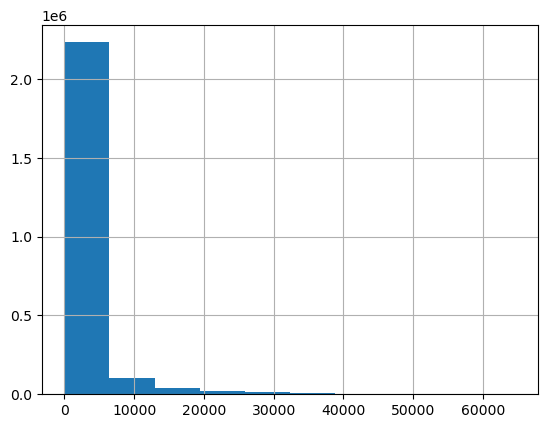

In [115]:
pdt_final_copy = pdt_final_copy[outlier_removal('m1_m2_avg_tpv')]
pdt_final_copy['loan_ltv'].hist()

In [116]:
print(f"Merchants after Loan LTV Outlier Removal: {pdt_final_copy.shape[0]}")

Merchants after Loan LTV Outlier Removal: 2423942


In [117]:
# pdt_final_copy = pdt_final_copy[outlier_removal('loan_ltv')]
# pdt_final_copy['loan_ltv'].hist()

In [118]:
# print(f"Merchants after Loan LTV Outlier Removal: {pdt_final_copy.shape[0]}")

In [119]:
# pdt_final_copy = pdt_final_copy[outlier_removal('swipe_ltv')]
# pdt_final_copy['swipe_ltv'].hist()

In [120]:
# print(f"Merchants after Swipe LTV Outlier Removal: {pdt_final_copy.shape[0]}")

In [121]:
# pdt_final_copy = pdt_final_copy[outlier_removal('speaker_ltv')]
# pdt_final_copy['speaker_ltv'].hist()

In [122]:
# print(f"Merchants after Speaker LTV Outlier Removal: {pdt_final_copy.shape[0]}")